## Содержание
0. Задание и необходимые библиотеки
1. Исследование и подготовка данных
2. GPT2, oбучение с нуля
3. GPT2, fine-tuning
4. BERT, feature extraction
5. BERT, fine-tuning
6. RobertaForSequenceClassification, fine-tuning
7. Выводы и что можно было сделать иначе

## 0. Задание и необходимые библиотеки
Задача: создать нейросеть, классифицирующую интенты. В файле выборка с репликами, разделёнными на категории (интенты). Фреймворк - PyTorch

Загружаем необходимые библиотеки

In [2]:
!pip install pyyaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install -q transformers tokenizers

In [4]:
import yaml
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
import random

import torch
import torch.nn as nn
from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast 
from transformers import GPT2Config
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import get_constant_schedule_with_warmup
from transformers import BertModel, BertTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from pylab import rcParams

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 1. Исследование и подготовка данных

In [7]:
with open('hello_nova_intents_0.2.2.yaml') as f:
    data = yaml.safe_load(f)

pprint(data)

{'data': [{'examples': ['Hi',
                        'Hello',
                        'Hi, bot',
                        'Good morning',
                        'Good afternoon',
                        'Good evening',
                        'Morning',
                        'Evening',
                        'Hey',
                        'Good day'],
           'intent': 'Hello'},
          {'examples': ['How are you?',
                        "What's up?",
                        'So how you been?',
                        'How you diddling?',
                        'How are you, baby?',
                        'How you doing?',
                        'How are doing?',
                        'What up, girl?',
                        'Howdy',
                        'How is it coming?',
                        'HI bot wassup?'],
           'intent': 'How are you?'},
          {'examples': ['What is this for?'], 'intent': 'What is this for?'},
          {'examples': ['How can yo

In [8]:
# загружаем данные в DataFrame
intents_data = pd.DataFrame(data['data'])
intents_data.head() 

,intent,examples
0,Hello,"[Hi, Hello, Hi, bot, Good morning, Good aftern..."
1,How are you?,"[How are you?, What's up?, So how you been?, H..."
2,What is this for?,[What is this for?]
3,How can you help me?,"[How can you help me?, How do you want to help..."
4,Are you a human?,[Are you a human?]


In [8]:
intents_data.describe()

,intent,examples
count,71,71
unique,71,71
top,Hello,"[Hi, Hello, Hi, bot, Good morning, Good aftern..."
freq,1,1


In [9]:
intents_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    71 non-null     object
 1   examples  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [9]:
# число классов
NUM_LABELS = len(intents_data.intent)
NUM_LABELS

71

Т.к. число классов у нас - 71, то нам предстоит задача многоклассовой классификации текста - Multiclass Text Classification. 

In [10]:
# как распределены объекты по классам

intents_data['number_of_examples'] = intents_data['examples'].apply(lambda x: len(x))
intents_data.head() 

,intent,examples,number_of_examples
0,Hello,"[Hi, Hello, Hi, bot, Good morning, Good aftern...",10
1,How are you?,"[How are you?, What's up?, So how you been?, H...",11
2,What is this for?,[What is this for?],1
3,How can you help me?,"[How can you help me?, How do you want to help...",10
4,Are you a human?,[Are you a human?],1


In [11]:
print(f'Min: {intents_data.number_of_examples.min()}, Max: {intents_data.number_of_examples.max()}')
# пропусков нет

Min: 1, Max: 28


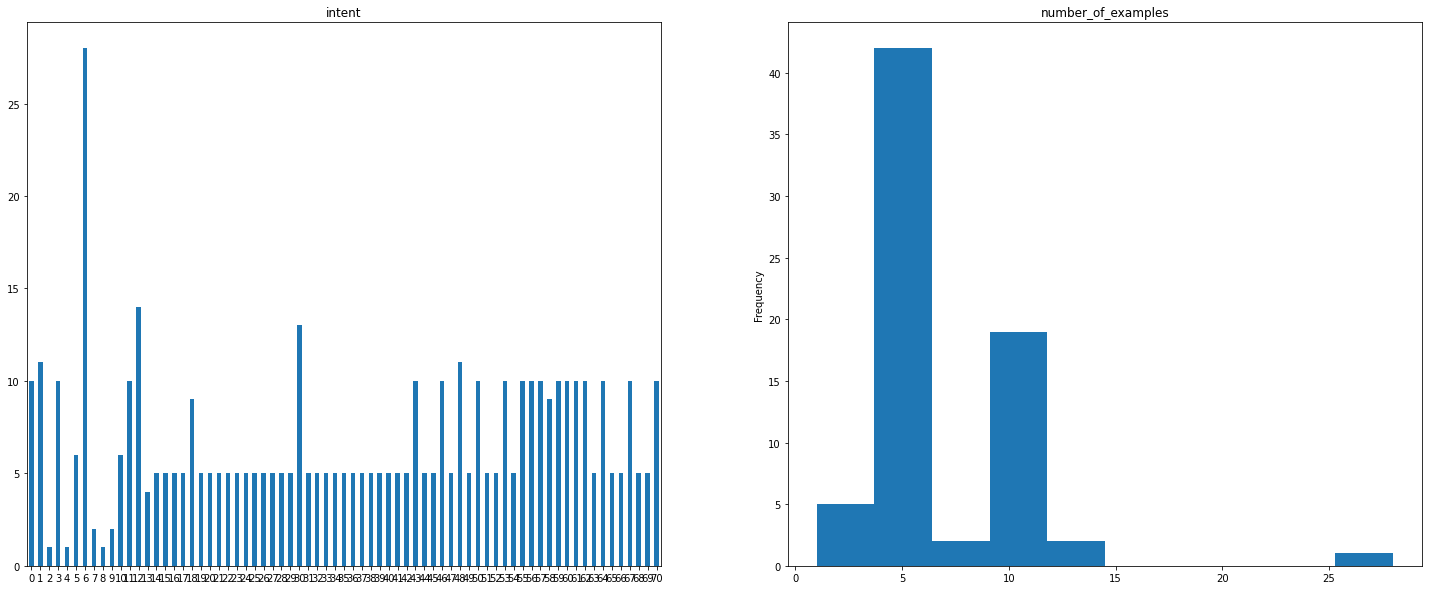

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

intents_data['number_of_examples'].plot.bar(ax=axes[0], rot=0, title='intent');
intents_data['number_of_examples'].plot.hist(ax=axes[1], title='number_of_examples');

Видим, что пропусков в данных нет. Больше всего классов с 5 объектами, затем с 10 объектами. Также есть классы, отличающиеся от большинства по количеству объектов: в меньшую сторону - 3 класса с 1 объектом, 2 класса с 3 объектами, 1 класс с 4 объектами; в большую сторону - 1 класс с 28 объектами. Таким образом, это несбалансированная выборка. 
Увеличим число объектов в малочисленных классах, для этого посмотрим на возможности различных методов аугментации данных: https://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/

In [31]:
# !pip install textattack

In [32]:
# !pip install tensorflow-text

In [33]:
# # Тексты для аугментации - классы с объектами меньше 5

# text_2 = intents_data.examples.loc[2]
# text_4 = intents_data.examples.loc[4]
# text_7 = intents_data.examples.loc[7]
# text_8 = intents_data.examples.loc[8]
# text_9 = intents_data.examples.loc[9]
# text_13 = intents_data.examples.loc[13]

# text_list = [text_2, text_4, text_7, text_8, text_9, text_13]

# pprint(text_list)

In [34]:
# # Wordnet augments text by replacing words with synonyms provided by WordNet
# from textattack.augmentation import WordNetAugmenter

# # Embedding augments text by replacing words with neighbors in the counter-fitted embedding space,
# # with a constraint to ensure their cosine similarity is at least 0.8
# from textattack.augmentation import EmbeddingAugmenter

# # EDA augments text with a combination of word insertions, substitutions, and deletions
# from textattack.augmentation import EasyDataAugmenter

# # CharSwapAugmenter augments text by substituting, deleting, inserting, and swapping adjacent characters
# from textattack.augmentation import CharSwapAugmenter

# wordnet_aug = WordNetAugmenter()
# embed_aug = EmbeddingAugmenter()
# eda_aug = EasyDataAugmenter()
# charswap_aug = CharSwapAugmenter()

In [35]:
# # функция для создания списка с аугментациями

# def text_aug(text):
#   for sent in text:
#     aug_texts = [sent, *wordnet_aug.augment(sent), *embed_aug.augment(sent),
#                  *eda_aug.augment(sent), *charswap_aug.augment(sent)]
#   return aug_texts

In [ ]:
# можно запустить ячейку несколько раз для большего выбора аугментаций 
# text_aug(text_2)
# text_aug(text_4)
# text_aug(text_8)
text_aug(['what is you?'])

['what is you?',
 'what is you?',
 'what is you?',
 'what is?',
 'what is you?',
 'you is what?',
 'what cost is you?',
 'what is you?']

Поскольку классов для аугментации немного, то можем выбрать наиболее адекватные примеры аугментации вручную

In [13]:
intents_data.at[2, 'examples'] = ['What is this for?',
                                  'What is this for?',
                                  'Whereof is this for?',
                                  'What is this for?',
                                  'What for this is?',
                                  'What is this?',
                                  'Wha is this for?']

intents_data.at[4, 'examples'] = ['Are you a human?',
                                  'Are you a man?',
                                  'Equal you a human?',
                                  'Are you a humans?',
                                  'Comprise you a human?',
                                  'Are you human?',
                                  'Are you a man human?',
                                  'Are you a humean?']

intents_data.at[7, 'examples'] = ['Why can I trust you?',
                                  'Why can 1 trust you?',
                                  'Why can I trusted you?',
                                  'Why can I trust?',
                                  'Why can I faith you?',
                                  'Can I trust you?',
                                  'Can I trusting you?',
                                  'Can I reliance you?',
                                  'Can I turst you?']     

intents_data.at[8, 'examples'] =  ["Why can't you understand me?",
                                   "Why can't you empathize me?",
                                   "Why can't you fathom me?",
                                   "Me can't you understand Why?",
                                   "Why can't you understand?",
                                   "Why can't you see me?",
                                   "wherefore can't you understand me?",
                                   "Why can't you understGnd me?",
                                   'Why cant you understand me?']     

intents_data.at[9, 'examples'] = ['Are you based on astrology?',
                                  'Are you basis on astrology?',
                                  'Are you based on base astrology?',
                                  'Abe you based on astrology?',
                                  'What are you based on?',
                                  'What are you bases on?',
                                  'What are you based?',
                                  'What are you base on?',
                                  'Waht are you based on?']         

intents_data.at[13, 'examples'] = ['Who are U?',
                                   'Who are You?',
                                   'WHO are You?',
                                   'Whose are You?',
                                   'What are you?',
                                   'What are live you?',
                                   'What you are?',
                                   'what is you?']                                                                                                   

Также выберем 13 случайных примеров из наиболее многочисленного класса

In [14]:
intents_data.at[6, 'examples'] = random.sample(intents_data.at[6, 'examples'], 13)

Теперь для каждого класса от 5 до 14 объектов

In [15]:
intents_data['number_of_examples'] = intents_data['examples'].apply(lambda x: len(x))
intents_data.head()

,intent,examples,number_of_examples
0,Hello,"[Hi, Hello, Hi, bot, Good morning, Good aftern...",10
1,How are you?,"[How are you?, What's up?, So how you been?, H...",11
2,What is this for?,"[What is this for?, What is this for?, Whereof...",7
3,How can you help me?,"[How can you help me?, How do you want to help...",10
4,Are you a human?,"[Are you a human?, Are you a man?, Equal you a...",8


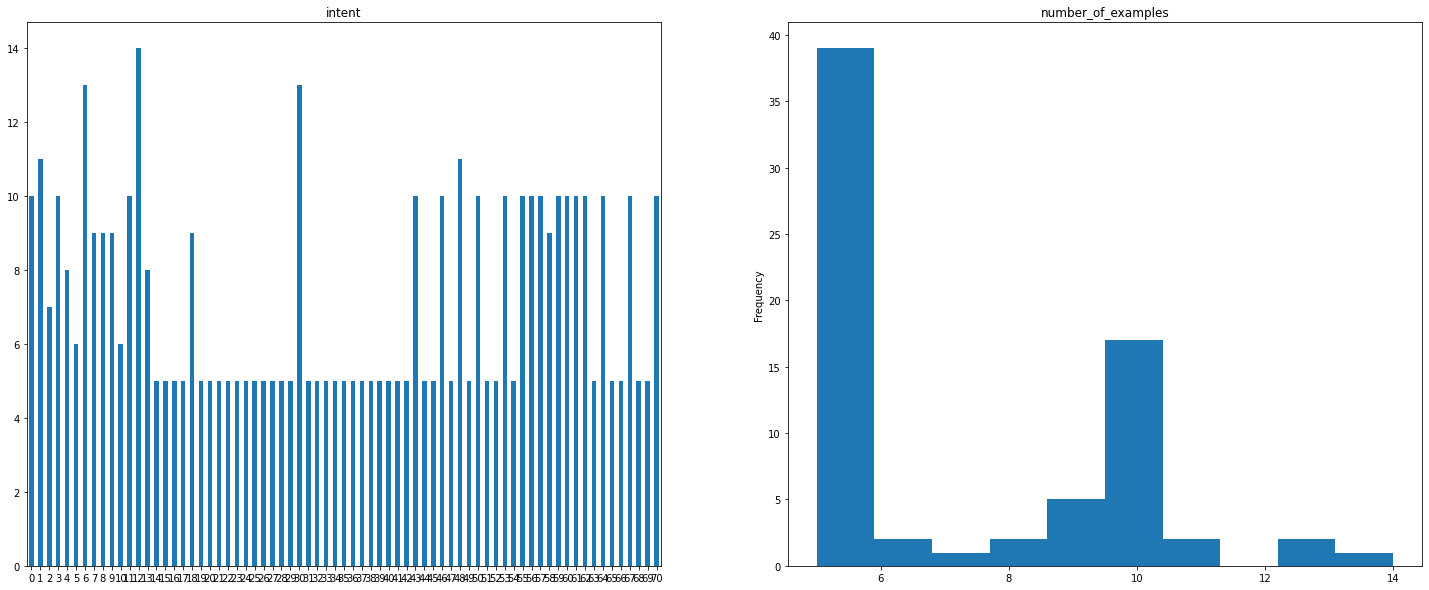

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

intents_data['number_of_examples'].plot.bar(ax=axes[0], rot=0, title='intent');
intents_data['number_of_examples'].plot.hist(ax=axes[1], title='number_of_examples');

Заменим лейблы на числа

In [18]:
# id_to_labels = pd.Series(intents_data.intent).to_dict()
# id_to_labels 

In [19]:
# labels_to_id= {v:k for k,v in id_to_labels .items()}
# labels_to_id

In [17]:
# intents_data['id'] = intents_data['intent'].map(labels_to_id)
intents_data['id'] = pd.factorize(intents_data.intent)[0]

intents_data.head()

,intent,examples,number_of_examples,id
0,Hello,"[Hi, Hello, Hi, bot, Good morning, Good aftern...",10,0
1,How are you?,"[How are you?, What's up?, So how you been?, H...",11,1
2,What is this for?,"[What is this for?, What is this for?, Whereof...",7,2
3,How can you help me?,"[How can you help me?, How do you want to help...",10,3
4,Are you a human?,"[Are you a human?, Are you a man?, Equal you a...",8,4


Распакуем объекты из examples, чтобы каждый объект был в отдельной строке

In [18]:
intents_data = intents_data.drop('number_of_examples', axis=1) # эта колонка не нужна для обучения нейросети
intents_data = intents_data.explode('examples').reset_index(drop=True) # Transform each element of a list-like to a row, replicating index values
intents_data # 507 объектов с аугментацией и 483 без нее

,intent,examples,id
0,Hello,Hi,0
1,Hello,Hello,0
2,Hello,"Hi, bot",0
3,Hello,Good morning,0
4,Hello,Good afternoon,0
...,...,...,...
502,(8) support 24/7 addenta,Are you capable of working with children?,70
503,(8) support 24/7 addenta,Is there any age limit working with you?,70
504,(8) support 24/7 addenta,Can you help the kids?,70
505,(8) support 24/7 addenta,Can you provide your assistance to kids?,70


In [19]:
len_sent = intents_data['examples'].apply(lambda x: len(x))
max(len_sent) # максимальная длина предложения - 94 знака

94

In [20]:
X, y = intents_data.examples, intents_data.id

In [21]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.15, 
                                                    random_state=42, stratify=y)

In [22]:
len(y_test.unique()) # в test представлены все классы 

71

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.17, 
                                                    random_state=42, stratify=y_tr)

In [24]:
len(y_val.unique()) # в val представлены все классы 

71

In [25]:
len(X_train), len(X_val), len(X_test)

(356, 74, 77)

Мы имеем мало объектов и много классов, поэтому простые модели классификации вряд ли имеет смысл рассматривать. Возьмем готовую архитектуру сети и несколько предобученных моделей и будем использовать их: GPT2, BERT, Roberta 

## 2. GPT2, oбучение с нуля

In [31]:
# для перевода текста в токены используем предобученный BPE-токенайзер
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста

In [37]:
# посмотри, как работает токенайзер

tokenizer.tokenize('Are you capable of working with children?')

['Are', 'Ġyou', 'Ġcapable', 'Ġof', 'Ġworking', 'Ġwith', 'Ġchildren', '?']

In [38]:
tokenizer.encode('Are you capable of working with children?')

[8491, 345, 6007, 286, 1762, 351, 1751, 30]

In [39]:
tokenizer.encode_plus('Are you capable of working with children?')

{'input_ids': [8491, 345, 6007, 286, 1762, 351, 1751, 30], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [40]:
tokenizer.encode_plus('Are you capable of working with children?', return_tensors="pt")

{'input_ids': tensor([[8491,  345, 6007,  286, 1762,  351, 1751,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [41]:
tokenizer.encode_plus(
    'Are you capable of working with children?', 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце
    return_tensors="pt" # возвращает pytorch тензоры
)

{'input_ids': tensor([[ 8491,   345,  6007,   286,  1762,   351,  1751,    30, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [33]:
class IntentsDataset(torch.utils.data.Dataset):
    def __init__(self, X_part, y_part, tokenizer, max_length=94):
        self.X = X_part.to_list()
        self.y = y_part.to_list()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(y_part)
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.X[idx]
        label = self.y[idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, max_length=self.max_length, 
                                                 padding="max_length", 
                                                 return_tensors="pt")
        return {
            "input_ids": tokenizer_output['input_ids'][0], 
            "mask": tokenizer_output['attention_mask'][0],
            'target': label
        }

    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.y)

In [34]:
train_dataset = IntentsDataset(X_train, y_train, tokenizer, max_length=94)
valid_dataset = IntentsDataset(X_val, y_val, tokenizer, max_length=94)
test_dataset = IntentsDataset(X_test, y_test, tokenizer, max_length=94)

In [32]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, drop_last=False)

In [33]:
next(iter(train_loader))

{'input_ids': tensor([[ 6090,   314,  1560,  ..., 50256, 50256, 50256],
         [ 8491,   345,  4673,  ..., 50256, 50256, 50256],
         [ 2215,   481,   314,  ..., 50256, 50256, 50256],
         ...,
         [ 2061,   338,   534,  ..., 50256, 50256, 50256],
         [ 6090,   314,   423,  ..., 50256, 50256, 50256],
         [ 8491,   345,  1654,  ..., 50256, 50256, 50256]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([33, 44, 31,  6, 10, 43, 49,  7, 24,  7, 66, 12, 57, 58, 39,  6, 60, 16,
         22, 45, 46, 30, 38,  9, 37, 22,  8,  1, 34, 12, 40, 11])}

In [101]:
x = next(iter(train_loader))
x['input_ids'].shape

torch.Size([32, 94])

In [44]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    pad_token_id=tokenizer.eos_token_id,
    num_labels=NUM_LABELS
)
model_GPT2 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [37]:
# посмотрим, что возвращает модель, если в неё подать данные

tr_batch = next(iter(train_loader))

tokens = tr_batch['input_ids'].to(device) # Получи токены из датасета
mask = tr_batch['mask'].to(device) # Получи маску из датасета

output = model_GPT2(input_ids=tokens, attention_mask=mask) # Посмотри на аутпут
output.keys()

odict_keys(['logits', 'past_key_values'])

In [38]:
output['logits'].shape # (batch_size, NUM_LABELS)

torch.Size([32, 71])

In [39]:
len(output['past_key_values']), len(output['past_key_values'][0]), output['past_key_values'][0][0].shape 
# length config.n_layers, with each tuple having 2 tensors of shape (batch_s, n_heads, seq_length, head_feature_dim)

(6, 2, torch.Size([32, 12, 94, 64]))

In [45]:
CLIP = 1
lr = 1e-3
num_epochs = 30
warmup_steps = 50

optimizer = torch.optim.AdamW(model_GPT2.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
total_steps = len(train_loader) * num_epochs # 12 * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [46]:
best_valid_f1 = -np.inf

# Train loop
for e in range(num_epochs):
    model_GPT2.train()
    train_loss = 0
    train_f1 = 0
    for batch in tqdm(train_loader):

        tokens = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        mask = batch['mask'].to(device)

        optimizer.zero_grad()

        output = model_GPT2(input_ids=tokens, attention_mask=mask)

        loss = criterion(output['logits'], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_GPT2.parameters(), CLIP)

        train_loss += loss.cpu().detach()

        train_f1 += f1_score(targets.cpu().detach(), 
                             torch.argmax(output['logits'], dim=1).cpu().detach(), 
                             average='macro')

        optimizer.step()
        scheduler.step()

    valid_f1 = 0
    valid_loss = 0
    model_GPT2.eval()

    with torch.no_grad():
        for batch in valid_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_GPT2(input_ids=tokens, attention_mask=mask)

          loss = criterion(output['logits'], targets)

          valid_loss += loss.cpu().detach()
          valid_f1 += f1_score(targets.cpu().detach(), 
                             torch.argmax(output['logits'], dim=1).cpu().detach(), 
                             average='macro')
 
    print(f"Epoch number: {e},"
          f"Train Loss: {train_loss / len(train_loader)},"
          f" Valid Loss: {valid_loss / len(valid_loader)},"
          f" Train F1: {train_f1 / len(train_loader)},"
          f" Valid F1: {valid_f1 /  len(valid_loader)}")     

    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model_GPT2.state_dict(), 'best_valid_f1_model_GPT2.pt')      
        
# Testing
test_f1 = 0
model_GPT2.load_state_dict(torch.load('best_valid_f1_model_GPT2.pt'))
model_GPT2.eval()
with torch.no_grad():
    for batch in test_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target']
          mask = batch['mask'].to(device)

          output = model_GPT2(input_ids=tokens, attention_mask=mask)

          test_f1  += f1_score(targets, 
                             torch.argmax(output['logits'], dim=1).cpu().detach(), 
                             average='macro')

print(f"Test F1: {test_f1 / len(test_loader)}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 0,Train Loss: 4.5905256271362305, Valid Loss: 4.289234161376953, Train F1: 0.011876000932514341, Valid F1: 0.027248020796407896


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 1,Train Loss: 3.5403974056243896, Valid Loss: 4.262797832489014, Train F1: 0.08404201572604349, Valid F1: 0.04745196324143693


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 2,Train Loss: 2.6793038845062256, Valid Loss: 3.8004820346832275, Train F1: 0.20917311386101747, Valid F1: 0.1432011078352542


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 3,Train Loss: 1.9782589673995972, Valid Loss: 3.6276562213897705, Train F1: 0.31468524127108893, Valid F1: 0.17311556329849012


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 4,Train Loss: 1.4909371137619019, Valid Loss: 3.633115768432617, Train F1: 0.4013580640589569, Valid F1: 0.1594787318624528


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 5,Train Loss: 1.0137239694595337, Valid Loss: 3.2608158588409424, Train F1: 0.5625596936353782, Valid F1: 0.3051139601139601


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 6,Train Loss: 0.7687373161315918, Valid Loss: 3.2181503772735596, Train F1: 0.6361249366037242, Valid F1: 0.26032016134114827


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 7,Train Loss: 0.4484195411205292, Valid Loss: 3.662508010864258, Train F1: 0.8129597493863171, Valid F1: 0.22792022792022792


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 8,Train Loss: 0.2635170817375183, Valid Loss: 3.9012820720672607, Train F1: 0.8845224626019644, Valid F1: 0.21584749938408473


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 9,Train Loss: 0.2525792717933655, Valid Loss: 3.6800031661987305, Train F1: 0.9145653800931579, Valid F1: 0.25210199157567575


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 10,Train Loss: 0.27986589074134827, Valid Loss: 3.5410916805267334, Train F1: 0.8782219395830507, Valid F1: 0.28691803691803686


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 11,Train Loss: 0.15283477306365967, Valid Loss: 3.45182204246521, Train F1: 0.9460799732408928, Valid F1: 0.28620353806400317


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 12,Train Loss: 0.12896215915679932, Valid Loss: 3.715486526489258, Train F1: 0.9503559840365395, Valid F1: 0.23642857142857143


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 13,Train Loss: 0.06902432441711426, Valid Loss: 3.8943798542022705, Train F1: 0.9750218916885585, Valid F1: 0.24119241192411925


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 14,Train Loss: 0.1015322282910347, Valid Loss: 3.604682207107544, Train F1: 0.9342555479145517, Valid F1: 0.3663551624527234


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 15,Train Loss: 0.07242435216903687, Valid Loss: 4.025736331939697, Train F1: 0.971910866910867, Valid F1: 0.275140370305609


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 16,Train Loss: 0.055454667657613754, Valid Loss: 3.9820454120635986, Train F1: 0.9731381919553964, Valid F1: 0.3045584045584045


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 17,Train Loss: 0.06589165329933167, Valid Loss: 3.890348434448242, Train F1: 0.9643874643874645, Valid F1: 0.2837606837606838


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 18,Train Loss: 0.04491117224097252, Valid Loss: 4.000579833984375, Train F1: 0.9753595170261837, Valid F1: 0.26229587936905013


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 19,Train Loss: 0.055474698543548584, Valid Loss: 3.970060348510742, Train F1: 0.9833314339981006, Valid F1: 0.30887816387816386


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 20,Train Loss: 0.029691211879253387, Valid Loss: 3.9918019771575928, Train F1: 0.9851900972590628, Valid F1: 0.3094237350051303


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 21,Train Loss: 0.026040835306048393, Valid Loss: 4.000236511230469, Train F1: 0.9816849816849818, Valid F1: 0.30063635063635064


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 22,Train Loss: 0.02298423834145069, Valid Loss: 4.043470859527588, Train F1: 0.9850712250712251, Valid F1: 0.3062580437580438


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 23,Train Loss: 0.021074237301945686, Valid Loss: 4.105931758880615, Train F1: 0.9778708864940748, Valid F1: 0.3023137111070359


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 24,Train Loss: 0.020035618916153908, Valid Loss: 4.060635089874268, Train F1: 0.9815873015873017, Valid F1: 0.3126670843776107


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 25,Train Loss: 0.016455460339784622, Valid Loss: 4.061642646789551, Train F1: 0.9864532019704434, Valid F1: 0.3126670843776107


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 26,Train Loss: 0.015508088283240795, Valid Loss: 4.055528163909912, Train F1: 0.9809389499389499, Valid F1: 0.3112781954887218


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 27,Train Loss: 0.014244313351809978, Valid Loss: 4.054672718048096, Train F1: 0.9922958214624882, Valid F1: 0.3112781954887218


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 28,Train Loss: 0.012092734687030315, Valid Loss: 4.038166046142578, Train F1: 0.9844650205761317, Valid F1: 0.3112781954887218


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 29,Train Loss: 0.012499959208071232, Valid Loss: 4.030759334564209, Train F1: 0.9857119341563786, Valid F1: 0.3112781954887218
Test F1: 0.3103836827841962


In [ ]:
#F1

# 15 эпох, lr = 1e-3, CLIP=1, num_warmup_steps = 40
# Train Loss: 0.02330632507801056, Valid Loss: 3.59637451171875, 
# Train F1: 0.9834310134310135, Valid F1: 0.2556325556325556
# Test F1: 0.26805020681785763

# 20 эпох, lr = 1e-3, CLIP=1, num_warmup_steps = 50
# Train Loss: 0.016814101487398148, Valid Loss: 3.535872220993042, 
# Train F1: 0.9778252611585945, Valid F1: 0.2882759065685895
# Test F1: 0.3123781676413255 !!!

# 20 эпох, lr = 1e-4, CLIP=1, num_warmup_steps = 60
# Train Loss: 0.019284073263406754, Valid Loss: 2.8966763019561768, 
# Train F1: 0.9859126984126984, Valid F1: 0.324647266313933
# Test F1: 0.300839706102864

# 20 эпох, lr = 1e-5, CLIP=1, num_warmup_steps = 80
# Train Loss: 0.7172064781188965, Valid Loss: 2.9001076221466064, 
# Train F1: 0.9145443584919545, Valid F1: 0.25157674304015765
# Test F1: 0.2526859785121719

# 20 эпох, lr = 1e-5, CLIP=1, num_warmup_steps = 50
# Train Loss: 0.6753080487251282, Valid Loss: 2.797386884689331, 
# Train F1: 0.9348188316579121, Valid F1: 0.25413105413105413
# Test F1: 0.23884582256675277

# 30 эпох, lr = 1e-3, CLIP=1, num_warmup_steps = 50
# Train Loss: 0.012499959208071232, Valid Loss: 4.030759334564209, 
# Train F1: 0.9857119341563786, Valid F1: 0.3112781954887218
# Test F1: 0.3103836827841962

Максимальное качество на тестовое выборке для модели GPT2, oбучение с нуля - F1: 0.312

## 3. GPT2, fine-tuning


Теперь попробуем обучить на наших данных предобученную модель GPT2

In [53]:
model_GPT2_pretrained = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    pad_token_id=tokenizer.eos_token_id,
    num_labels=NUM_LABELS
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# model_GPT2_pretrained.eval()

In [55]:
CLIP = 1
lr = 1e-3
num_epochs = 20
warmup_steps = 100

optimizer = torch.optim.AdamW(model_GPT2_pretrained.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
total_steps = len(train_loader) * num_epochs # 12 * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [56]:
best_valid_f1 = -np.inf

# Train loop
for e in range(num_epochs):
    model_GPT2_pretrained.train()
    train_f1 = 0
    train_loss = 0
    for batch in tqdm(train_loader):

        tokens = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        mask = batch['mask'].to(device)

        optimizer.zero_grad()

        output = model_GPT2_pretrained(input_ids=tokens, attention_mask=mask)
        # print(output['logits'])

        loss = criterion(output['logits'], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_GPT2_pretrained.parameters(), CLIP)

        train_loss += loss.cpu().detach()
        train_f1 += f1_score(targets.cpu().detach(), 
                             torch.argmax(output['logits'], dim=1).cpu().detach(), 
                             average='macro')

        optimizer.step()
        scheduler.step()

    valid_f1 = 0
    valid_loss = 0
    model_GPT2_pretrained.eval()

    with torch.no_grad():
        for batch in valid_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_GPT2_pretrained(input_ids=tokens, attention_mask=mask)

          loss = criterion(output['logits'], targets)

          valid_loss += loss.cpu().detach()
          valid_f1 += f1_score(targets.cpu().detach(), 
                             torch.argmax(output['logits'], dim=1).cpu().detach(), 
                             average='macro')

 
    print(f"Epoch number: {e},"
          f" Train Loss: {train_loss / len(train_loader)},"
          f" Valid Loss: {valid_loss / len(valid_loader)},"
          f" Train f1: {train_f1 / len(train_loader)},"
          f" Valid f1: {valid_f1 /  len(valid_loader)}")     

    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model_GPT2_pretrained.state_dict(), 'best_valid_f1_model_GPT2_pretrained.pt')      
        
# Testing
test_f1 = 0
model_GPT2_pretrained.load_state_dict(torch.load('best_valid_f1_model_GPT2_pretrained.pt'))
model_GPT2_pretrained.eval()
with torch.no_grad():
    for batch in test_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target']
          mask = batch['mask'].to(device)

          output = model_GPT2_pretrained(input_ids=tokens, attention_mask=mask)

          test_f1 += f1_score(targets, 
                             torch.argmax(output['logits'], dim=1).cpu().detach(), 
                             average='macro')

print(f"Test f1: {test_f1 / len(test_loader)}")              

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 0, Train Loss: 6.168338775634766, Valid Loss: 4.511222839355469, Train f1: 0.001082375478927203, Valid f1: 0.0006516780710329097


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 1, Train Loss: 4.32498836517334, Valid Loss: 4.380524158477783, Train f1: 0.01269958051208051, Valid f1: 0.015584415584415584


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 2, Train Loss: 3.983096122741699, Valid Loss: 3.852463960647583, Train f1: 0.0555759532602294, Valid f1: 0.08265765765765766


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 3, Train Loss: 3.0308094024658203, Valid Loss: 2.7330238819122314, Train f1: 0.2053559228853742, Valid f1: 0.26587783561467765


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 4, Train Loss: 1.5407053232192993, Valid Loss: 2.11674165725708, Train f1: 0.5094780615347788, Valid f1: 0.30048411627359


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 5, Train Loss: 0.6045874953269958, Valid Loss: 2.1998207569122314, Train f1: 0.7643934563536204, Valid f1: 0.38032581453634084


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 6, Train Loss: 0.3832382261753082, Valid Loss: 1.7773534059524536, Train f1: 0.8340344778523153, Valid f1: 0.44501424501424497


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 7, Train Loss: 0.30796292424201965, Valid Loss: 2.103644371032715, Train f1: 0.8615875296478744, Valid f1: 0.3282770575453502


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 8, Train Loss: 0.32422348856925964, Valid Loss: 2.8117034435272217, Train f1: 0.8526866315180491, Valid f1: 0.3735042735042735


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 9, Train Loss: 0.4325638711452484, Valid Loss: 2.592700242996216, Train f1: 0.8704727366255143, Valid f1: 0.41811490978157645


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 10, Train Loss: 0.16228051483631134, Valid Loss: 2.573580026626587, Train f1: 0.9156136349814511, Valid f1: 0.35752273252273253


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 11, Train Loss: 0.292184442281723, Valid Loss: 2.0250909328460693, Train f1: 0.8841411058077725, Valid f1: 0.4438798554652213


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 12, Train Loss: 0.14654240012168884, Valid Loss: 2.206308126449585, Train f1: 0.9272523059457923, Valid f1: 0.41168091168091164


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 13, Train Loss: 0.14027996361255646, Valid Loss: 2.1086418628692627, Train f1: 0.9325091506275079, Valid f1: 0.4612085769980507


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 14, Train Loss: 0.07799256592988968, Valid Loss: 2.2252728939056396, Train f1: 0.9545477871564829, Valid f1: 0.43854854854854847


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 15, Train Loss: 0.10108762979507446, Valid Loss: 2.3084652423858643, Train f1: 0.9663986013986015, Valid f1: 0.4532727849801021


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 16, Train Loss: 0.05864131450653076, Valid Loss: 2.0848846435546875, Train f1: 0.9706828437633036, Valid f1: 0.518755935422602


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 17, Train Loss: 0.04368269070982933, Valid Loss: 1.9524062871932983, Train f1: 0.9586556776556777, Valid f1: 0.48155676001204456


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 18, Train Loss: 0.028608346357941628, Valid Loss: 1.991956353187561, Train f1: 0.9765128205128205, Valid f1: 0.49905033238366575


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 19, Train Loss: 0.01686362363398075, Valid Loss: 2.010138750076294, Train f1: 0.9853869895536561, Valid f1: 0.48670465337132
Test f1: 0.4964701543648912


In [ ]:
# f1

#lr = 1e-3, num_epochs = 15, CLIP = 1, num_warmup_steps = 80
# Train Loss: 0.028459766879677773, Valid Loss: 2.1448304653167725, 
# Train f1: 0.9835854864590496, Valid f1: 0.41869524237945294
# Test f1: 0.41380369811742357

#lr = 1e-3, num_epochs = 20, CLIP = 1, num_warmup_steps = 100
# Train Loss: 0.01686362363398075, Valid Loss: 2.010138750076294, 
# Train f1: 0.9853869895536561, Valid f1: 0.48670465337132
# Test f1: 0.4964701543648912

Дообучение предобученной модели GPT2ForSequenceClassification подняло качество с 0.312 до 0.496


## 4. BERT, feature extraction

Попробуем другую предобученную модель - BERT, но используем ее сначала как экстрактор фичей для модели логистической регрессии

In [35]:
model_BERT, BERT_tokenizer, BERT_pretrained_weights = (BertModel, BertTokenizer, 'bert-base-uncased')

In [36]:
B_tokenizer = BERT_tokenizer.from_pretrained(BERT_pretrained_weights)

In [59]:
B_tokenizer.encode_plus(
    'Are you capable of working with children?', 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt" # возвращает pytorch тензоры
)

{'input_ids': tensor([[ 101, 2024, 2017, 5214, 1997, 2551, 2007, 2336, 1029,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

In [37]:
BERT_train_dataset = IntentsDataset(X_train, y_train, B_tokenizer, max_length=94)
BERT_valid_dataset = IntentsDataset(X_val, y_val, B_tokenizer, max_length=94)
BERT_test_dataset = IntentsDataset(X_test, y_test, B_tokenizer, max_length=94)

In [38]:
batch_size = 32

BERT_train_loader = torch.utils.data.DataLoader(BERT_train_dataset, batch_size, shuffle=True, drop_last=False)
BERT_valid_loader = torch.utils.data.DataLoader(BERT_valid_dataset, batch_size, shuffle=False, drop_last=False)
BERT_test_loader = torch.utils.data.DataLoader(BERT_test_dataset, batch_size, shuffle=False, drop_last=False)

In [62]:
next(iter(BERT_train_loader))

{'input_ids': tensor([[ 101, 2024, 2017,  ...,    0,    0,    0],
         [ 101, 2017, 2024,  ...,    0,    0,    0],
         [ 101, 2054, 2064,  ...,    0,    0,    0],
         ...,
         [ 101, 2052, 2017,  ...,    0,    0,    0],
         [ 101, 2054, 2529,  ...,    0,    0,    0],
         [ 101, 2064, 2017,  ...,    0,    0,    0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([26, 38,  6, 34, 43, 28, 63, 27, 61, 64, 46, 48,  2, 62, 63, 39,  9, 24,
         25, 34, 16, 33, 60, 12, 58, 64, 56,  8, 46, 33, 66, 68])}

In [64]:
model_BERT_FE = model_BERT.from_pretrained(BERT_pretrained_weights, num_labels=NUM_LABELS)
model_BERT_FE.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
def get_xy(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            
            inputs = batch["input_ids"].to(device)
            attention_mask = batch['mask'].to(device)

            last_hidden_states = model_BERT_FE(inputs, attention_mask=attention_mask)
            
            features.append(last_hidden_states[0].cpu())
            labels.append(batch['target'])

    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy() # токен CLS
    labels = torch.cat(labels, dim=0).numpy()
    
    return features, labels

In [66]:
train_features, train_labels = get_xy(BERT_train_loader)
valid_features, valid_labels = get_xy(BERT_valid_loader)
test_features, test_labels = get_xy(BERT_test_loader)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [67]:
lr_clf = LogisticRegression(class_weight='balanced', multi_class='ovr')
lr_clf.fit(train_features, train_labels)
lr_clf.fit(valid_features, valid_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(class_weight='balanced', multi_class='ovr')

In [68]:
y_pred = lr_clf.predict(test_features)
f1_score(test_labels, y_pred, average='macro')

0.25539906103286386

Подход с спользованием BERT как экстрактор фичей для модели логистической регрессии проиграл дообученной модели GPT2, качество f1 - 0.255

## 5. BERT, fine-tuning

Теперь дообучим BERT также, как мы это делали с GPT2

In [39]:
class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.2):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(768, NUM_LABELS)
    
    def forward(self, inputs, attention_mask):
        
        outp = self.bert(inputs, attention_mask) 
        outp = outp[0][:, 0, :] # [32, 768] # токен CLS
        outp = self.fc_1(self.dropout(outp)) # [32, NUM_LABELS])
        proba = self.relu(outp).squeeze(1)  # [32])
        
        return proba

In [47]:
model = model_BERT.from_pretrained(BERT_pretrained_weights, num_labels=NUM_LABELS).to(device)
model_BERT_FT = BertClassifier(model).to(device)

num_epochs = 20
warmup_steps = 100
CLIP = 1
lr=1e-4

optimizer = torch.optim.AdamW(model_BERT_FT.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
total_steps = len(BERT_train_loader) * num_epochs # 12 * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
best_valid_f1 = -np.inf

# Train loop
for e in range(num_epochs):
    model_BERT_FT.train()
    train_f1 = 0
    train_loss = 0
    for batch in tqdm(BERT_train_loader):

        tokens = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        mask = batch['mask'].to(device)

        optimizer.zero_grad()

        output = model_BERT_FT(tokens, mask)
        # print(output['logits'])

        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_BERT_FT.parameters(), CLIP)

        train_loss += loss.cpu().detach()
        train_f1 += f1_score(targets.cpu().detach(), 
                             torch.argmax(output, dim=1).cpu().detach(), 
                             average='macro')

        optimizer.step()
        scheduler.step()

    valid_f1 = 0
    valid_loss = 0
    model_BERT_FT.eval()

    with torch.no_grad():
        for batch in BERT_valid_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_BERT_FT(tokens, mask)

          loss = criterion(output, targets)

          valid_loss += loss.cpu().detach()
          valid_f1 += f1_score(targets.cpu().detach(), 
                               torch.argmax(output, dim=1).cpu().detach(), 
                               average='macro')

 
    print(f"Epoch number: {e},"
          f" Train Loss: {train_loss / len(BERT_train_loader)},"
          f" Valid Loss: {valid_loss / len(BERT_valid_loader)},"
          f" Train f1: {train_f1 / len(BERT_train_loader)},"
          f" Valid f1: {valid_f1 /  len(BERT_valid_loader)}")     

    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model_BERT_FT.state_dict(), 'best_valid_f1_model_BERT_FT.pt')      
        
# Testing
test_f1 = 0
model_BERT_FT.load_state_dict(torch.load('best_valid_f1_model_BERT_FT.pt'))
model_BERT_FT.eval()
with torch.no_grad():
    for batch in BERT_test_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target']
          mask = batch['mask'].to(device)

          output = model_BERT_FT(tokens, mask)

          test_f1 += f1_score(targets, 
                              torch.argmax(output, dim=1).cpu().detach(), 
                              average='macro')

print(f"Test f1: {test_f1 / len(BERT_test_loader)}")              

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 0, Train Loss: 4.281700611114502, Valid Loss: 4.282974720001221, Train f1: 0.015518859873698582, Valid f1: 0.032818532818532815


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 1, Train Loss: 4.243985652923584, Valid Loss: 4.241134166717529, Train f1: 0.012364930007763003, Valid f1: 0.012857331484782466


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 2, Train Loss: 4.145158767700195, Valid Loss: 4.122231960296631, Train f1: 0.04081944503723108, Valid f1: 0.04899899899899899


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 3, Train Loss: 3.8435380458831787, Valid Loss: 3.908201217651367, Train f1: 0.14504688088783832, Valid f1: 0.11695116168800379


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 4, Train Loss: 3.3731276988983154, Valid Loss: 3.5464084148406982, Train f1: 0.3018031246697505, Valid f1: 0.19724339724339723


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 5, Train Loss: 2.677109956741333, Valid Loss: 3.122624635696411, Train f1: 0.4836791526998541, Valid f1: 0.23611111111111108


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 6, Train Loss: 2.158665418624878, Valid Loss: 2.7566330432891846, Train f1: 0.5770012432225076, Valid f1: 0.29595906738763883


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 7, Train Loss: 1.5445661544799805, Valid Loss: 2.2953248023986816, Train f1: 0.7227871243403959, Valid f1: 0.3945569050832209


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 8, Train Loss: 0.9488288760185242, Valid Loss: 1.8667079210281372, Train f1: 0.84928581954444, Valid f1: 0.4925753259086592


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 9, Train Loss: 0.5489946007728577, Valid Loss: 1.7061400413513184, Train f1: 0.8955885756077328, Valid f1: 0.491907697170855


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 10, Train Loss: 0.35102882981300354, Valid Loss: 1.697087287902832, Train f1: 0.942331153308165, Valid f1: 0.43650793650793646


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 11, Train Loss: 0.2383529543876648, Valid Loss: 1.6984246969223022, Train f1: 0.9545615966267308, Valid f1: 0.45841830359374214


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 12, Train Loss: 0.1532147079706192, Valid Loss: 1.5563169717788696, Train f1: 0.9597452310000203, Valid f1: 0.4893407761828814


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 13, Train Loss: 0.12965141236782074, Valid Loss: 1.5858620405197144, Train f1: 0.9613544462336733, Valid f1: 0.4858919832604043


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 14, Train Loss: 0.11020556837320328, Valid Loss: 1.5420080423355103, Train f1: 0.9565582364495407, Valid f1: 0.4892031892031892


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 15, Train Loss: 0.09829762578010559, Valid Loss: 1.5220993757247925, Train f1: 0.968199233716475, Valid f1: 0.5296072296072296


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 16, Train Loss: 0.08625014871358871, Valid Loss: 1.536152720451355, Train f1: 0.9648146950003834, Valid f1: 0.5516209099542433


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 17, Train Loss: 0.09241568297147751, Valid Loss: 1.5678471326828003, Train f1: 0.9541119611750962, Valid f1: 0.49821219821219814


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 18, Train Loss: 0.08272319287061691, Valid Loss: 1.5605731010437012, Train f1: 0.9557073386383731, Valid f1: 0.49821219821219814


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 19, Train Loss: 0.07555633038282394, Valid Loss: 1.5619598627090454, Train f1: 0.9655677503128778, Valid f1: 0.49821219821219814
Test f1: 0.5409611992945326


In [ ]:
# num_epochs = 20, warmup_steps = 100, CLIP = 1, lr=1e-4
# Train Loss: 0.07555633038282394, Valid Loss: 1.5619598627090454, 
# Train f1: 0.9655677503128778, Valid f1: 0.49821219821219814
# Test f1: 0.5409611992945326

In [49]:
# best_model = BertClassifier(model).to(device)
# best_model.load_state_dict(torch.load('BERT_best-val-model_1.pt'))

# pred_labels = []
# true_labels = []

# best_model.eval()
# with torch.no_grad():
#     for i, batch in tqdm(enumerate(BERT_test_loader)):

#         inputs = batch["input_ids"].to(device)
#         labels = batch['target'].to(device)
#         attention_mask = batch['mask'].to(device)
#         pred = best_model(inputs, attention_mask)

#         pred_labels.append(pred.argmax(dim=1).cpu())
#         true_labels.append(labels.cpu().numpy())

In [50]:
# pred_labels

In [51]:
# from sklearn.metrics import accuracy_score

# true_labels = np.concatenate(true_labels, axis=0)
# pred_labels = np.concatenate(pred_labels, axis=0)
# accuracy_score(true_labels, pred_labels)

BERT работает немного лучше GPT2, максимально достигнутое качество f1 - 0.54

## 6. RobertaForSequenceClassification, fine-tuning

И попробуем дообучить еще одну модель - RobertaForSequenceClassification

In [56]:
model_Roberta, tokenizer_class, pretrained_weights = (RobertaForSequenceClassification, RobertaTokenizer, 'roberta-base')
Roberta_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [57]:
Roberta_train_dataset = IntentsDataset(X_train, y_train, Roberta_tokenizer, max_length=94)
Roberta_valid_dataset = IntentsDataset(X_val, y_val, Roberta_tokenizer, max_length=94)
Roberta_test_dataset = IntentsDataset(X_test, y_test, Roberta_tokenizer, max_length=94)

In [58]:
batch_size = 32

Roberta_train_loader = torch.utils.data.DataLoader(Roberta_train_dataset, batch_size, shuffle=True, drop_last=False)
Roberta_valid_loader = torch.utils.data.DataLoader(Roberta_valid_dataset, batch_size, shuffle=False, drop_last=False)
Roberta_test_loader = torch.utils.data.DataLoader(Roberta_test_dataset, batch_size, shuffle=False, drop_last=False)

In [59]:
next(iter(Roberta_train_loader))

{'input_ids': tensor([[    0, 17485,    47,  ...,     1,     1,     1],
         [    0,  2264,    16,  ...,     1,     1,     1],
         [    0,  8275,    47,  ...,     1,     1,     1],
         ...,
         [    0, 12375,    16,  ...,     1,     1,     1],
         [    0,  2264,    16,  ...,     1,     1,     1],
         [    0,  7608,   109,  ...,     1,     1,     1]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([56, 61, 63, 35, 68, 48, 66, 12, 42,  8, 65, 70, 51, 48, 15, 36,  4, 57,
         30, 13, 40, 34, 25, 58,  1,  6,  4,  7,  3, 26, 62, 11])}

In [60]:
model_Roberta = model_Roberta.from_pretrained(pretrained_weights, num_labels=NUM_LABELS).to(device)

num_epochs = 20
warmup_steps = 100
CLIP = 1
lr=1e-4

optimizer = torch.optim.AdamW(model_Roberta.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
total_steps = len(Roberta_train_loader) * num_epochs # 10 * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [62]:
best_valid_f1 = -np.inf

# Train loop
for e in range(num_epochs):
    model_Roberta.train()
    train_f1 = 0
    train_loss = 0
    for batch in tqdm(Roberta_train_loader):

        tokens = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        mask = batch['mask'].to(device)

        optimizer.zero_grad()

        output = model_Roberta(tokens, mask)
        # print(output['logits'])

        loss = criterion(output['logits'], targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_Roberta.parameters(), CLIP)

        train_loss += loss.cpu().detach()
        train_f1 += f1_score(targets.cpu().detach(), 
                             torch.argmax(output['logits'], dim=1).cpu().detach(), 
                             average='macro')

        optimizer.step()
        scheduler.step()

    valid_f1 = 0
    valid_loss = 0
    model_Roberta.eval()

    with torch.no_grad():
        for batch in Roberta_valid_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target'].to(device)
          mask = batch['mask'].to(device)

          output = model_Roberta(tokens, mask)

          loss = criterion(output['logits'], targets)

          valid_loss += loss.cpu().detach()
          valid_f1 += f1_score(targets.cpu().detach(), 
                               torch.argmax(output['logits'], dim=1).cpu().detach(), 
                               average='macro')

 
    print(f"Epoch number: {e},"
          f" Train Loss: {train_loss / len(Roberta_train_loader)},"
          f" Valid Loss: {valid_loss / len(Roberta_valid_loader)},"
          f" Train f1: {train_f1 / len(Roberta_train_loader)},"
          f" Valid f1: {valid_f1 /  len(Roberta_valid_loader)}")     

    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model_Roberta.state_dict(), 'best_valid_f1_model_Roberta.pt')      
        
# Testing
test_f1 = 0
model_Roberta.load_state_dict(torch.load('best_valid_f1_model_Roberta.pt'))
model_Roberta.eval()
with torch.no_grad():
    for batch in Roberta_test_loader:
          tokens = batch['input_ids'].to(device)
          targets = batch['target']
          mask = batch['mask'].to(device)

          output = model_Roberta(tokens, mask)

          test_f1 += f1_score(targets, 
                              torch.argmax(output['logits'], dim=1).cpu().detach(), 
                              average='macro')

print(f"Test f1: {test_f1 / len(Roberta_test_loader)}")              

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 0, Train Loss: 4.272895336151123, Valid Loss: 4.264516353607178, Train f1: 0.0006238977072310405, Valid f1: 0.006060606060606061


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 1, Train Loss: 4.254880428314209, Valid Loss: 4.262820720672607, Train f1: 0.0032665746951461238, Valid f1: 0.0006734006734006734


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 2, Train Loss: 4.20747709274292, Valid Loss: 4.201839447021484, Train f1: 0.009139173866403469, Valid f1: 0.06152250735584069


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 3, Train Loss: 3.989816665649414, Valid Loss: 3.8948113918304443, Train f1: 0.09064260011133024, Valid f1: 0.1293349113524552


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 4, Train Loss: 3.5231189727783203, Valid Loss: 3.467773675918579, Train f1: 0.2780612320032506, Valid f1: 0.200661911188227


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 5, Train Loss: 2.9397382736206055, Valid Loss: 3.0394458770751953, Train f1: 0.40559757248030176, Valid f1: 0.2449199199199199


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 6, Train Loss: 2.346055746078491, Valid Loss: 2.6162071228027344, Train f1: 0.5438131579969862, Valid f1: 0.3522661122661123


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 7, Train Loss: 1.7051841020584106, Valid Loss: 2.2443082332611084, Train f1: 0.7223984554819797, Valid f1: 0.4289580789580789


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 8, Train Loss: 1.2217375040054321, Valid Loss: 2.051248788833618, Train f1: 0.8557423118246872, Valid f1: 0.42680818470292153


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 9, Train Loss: 0.8668243885040283, Valid Loss: 1.854108214378357, Train f1: 0.8960762077356671, Valid f1: 0.4488304093567251


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 10, Train Loss: 0.6836380362510681, Valid Loss: 1.7964709997177124, Train f1: 0.9222825237767767, Valid f1: 0.4454191033138401


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 11, Train Loss: 0.4588841497898102, Valid Loss: 1.6327271461486816, Train f1: 0.9603711535858367, Valid f1: 0.4945469945469945


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 12, Train Loss: 0.32303115725517273, Valid Loss: 1.5755877494812012, Train f1: 0.980258784425451, Valid f1: 0.4461313540260908


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 13, Train Loss: 0.2274676412343979, Valid Loss: 1.5007919073104858, Train f1: 0.9803685686294382, Valid f1: 0.4969386052719386


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 14, Train Loss: 0.187994584441185, Valid Loss: 1.4916871786117554, Train f1: 0.9780746073849523, Valid f1: 0.4926900584795321


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 15, Train Loss: 0.14725026488304138, Valid Loss: 1.5096246004104614, Train f1: 0.9826495726495726, Valid f1: 0.47899610136452236


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 16, Train Loss: 0.12834432721138, Valid Loss: 1.5357846021652222, Train f1: 0.9756226284004063, Valid f1: 0.48248248248248243


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 17, Train Loss: 0.10911164432764053, Valid Loss: 1.537697434425354, Train f1: 0.9859770114942528, Valid f1: 0.49724724724724717


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 18, Train Loss: 0.09427943080663681, Valid Loss: 1.5444813966751099, Train f1: 0.9894179894179894, Valid f1: 0.47497497497497493


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch number: 19, Train Loss: 0.08768320083618164, Valid Loss: 1.5509899854660034, Train f1: 0.9856090534979424, Valid f1: 0.47114219482640535
Test f1: 0.6138888888888889


In [ ]:
# num_epochs = 20, warmup_steps = 100, CLIP = 1, lr=1e-4
# Train Loss: 0.08768320083618164, Valid Loss: 1.5509899854660034, 
# Train f1: 0.9856090534979424, Valid f1: 0.47114219482640535
# Test f1: 0.6138888888888889

In [63]:
# best_model = Roberta_model.to(device)
# best_model.load_state_dict(torch.load('Roberta_best-val-model.pt'))

# pred_labels = []
# true_labels = []

# best_model.eval()
# with torch.no_grad():
#     for i, batch in tqdm(enumerate(Roberta_test_loader)):

#         inputs = batch["input_ids"].to(device)
#         labels = batch['target'].to(device)
#         attention_mask = batch['mask'].to(device)
#         pred = best_model(inputs, attention_mask)
#         pred = pred['logits']

#         pred_labels.append(pred.argmax(dim=1).cpu())
#         true_labels.append(labels.cpu().numpy())

In [64]:
# pred_labels

In [65]:
# from sklearn.metrics import accuracy_score

# true_labels = np.concatenate(true_labels, axis=0)
# pred_labels = np.concatenate(pred_labels, axis=0)
# accuracy_score(true_labels, pred_labels)

Дообученная RobertaForSequenceClassification работает еще немного лучше, чем BERT, максимальное качество  f1 - 0.614

## 7. Выводы и что можно было сделать иначе

Дообучение предобученных моделей сработало лучше всего в данной задаче многоклассовой классификации. При этом победила модель RobertaForSequenceClassification с f1 - 0.614

### Что можно было сделать иначе

1. Смотрела только метрику  F1, можно было считать еще ROC-AUC, рисовать Confusion Matrix и Classification Report
2. Больший перебор гиперпараметров
3. Кроме учтенных гиперпараметром можно было поперебирать различные значения SEED
